#**Adult Dataset**
https://archive.ics.uci.edu/dataset/2/adult

## Instalations and Imports

In [67]:
pip install ucimlrepo

In [68]:
pip install lime

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# for some errors
# from importlib import reload
# plt=reload(plt)

## Dataset Preprocessing

### Getting Dataset

In [70]:
adult = fetch_ucirepo(id=2)
data = adult.data.original
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Replacing invalid data

In [71]:
print(data.isin(['?']).sum())
data['native-country'] = data['native-country'].replace('?', np.nan)
data['occupation'] = data['occupation'].replace('?', np.nan)
data['workclass'] = data['workclass'].replace('?', np.nan)
print(data.isin(['?']).sum())

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [72]:
df = data.copy()
df.dropna(how='any',inplace=True)
df.drop_duplicates()
print(df.shape, '\n', df.columns)

(45222, 15) 
 Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')


### Dataset Overview

#### Numerical Features

In [73]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,4.522200e+04,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,1.897347e+05,10.118460,1101.430344,88.595418,40.938017
std,13.217870,1.056392e+05,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.173882e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783160e+05,10.000000,0.000000,0.000000,40.000000
75%,47.000000,2.379260e+05,13.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


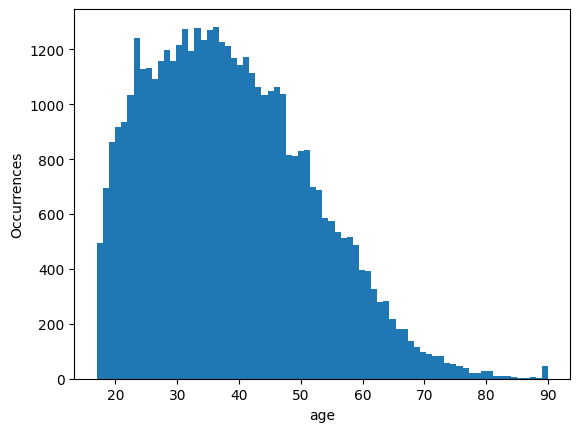

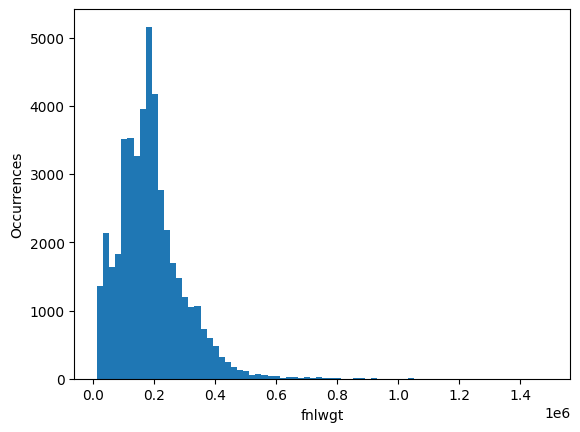

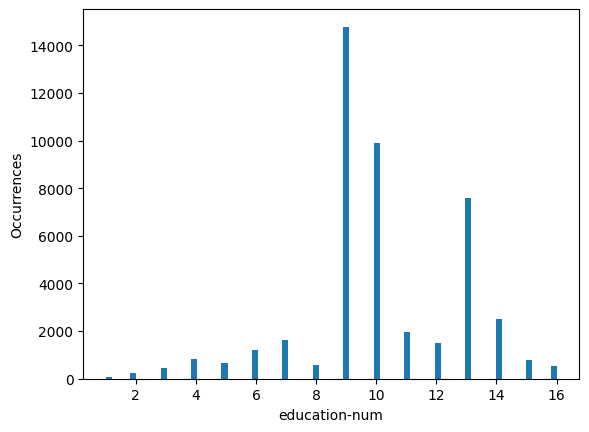

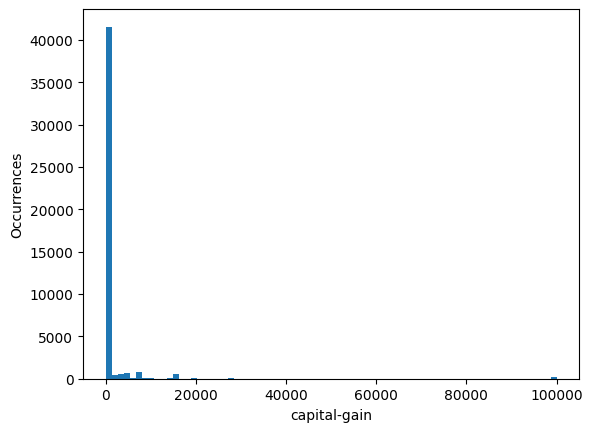

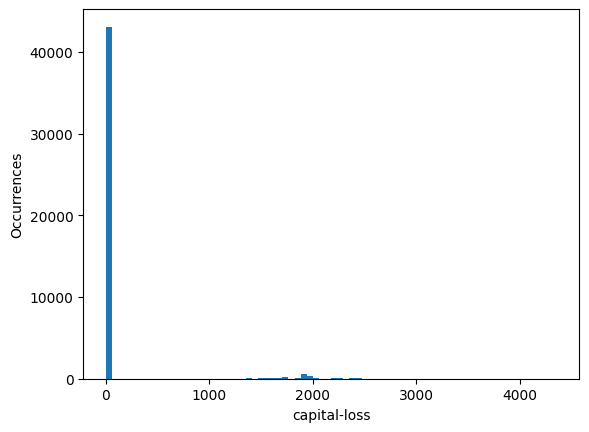

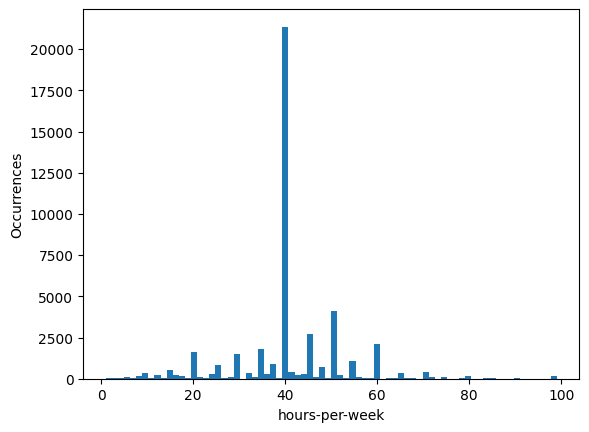

In [74]:
for num_feature in df.select_dtypes(exclude='object').columns:
  df[num_feature].plot(kind='hist', bins=74)
  plt.ylabel('Occurrences')
  plt.xlabel(num_feature)
  plt.show()

#### Categorical Features

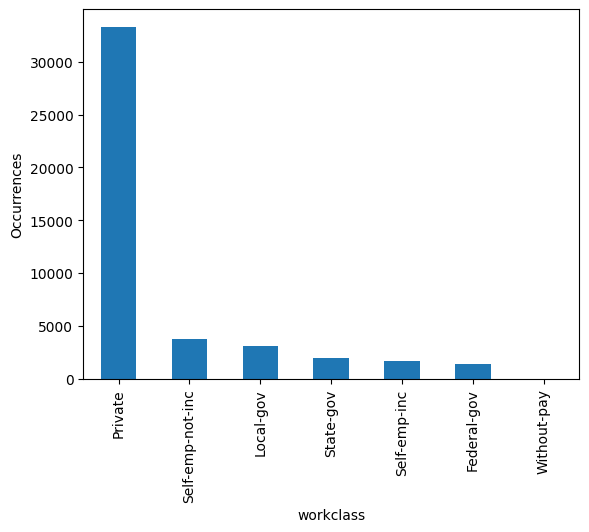

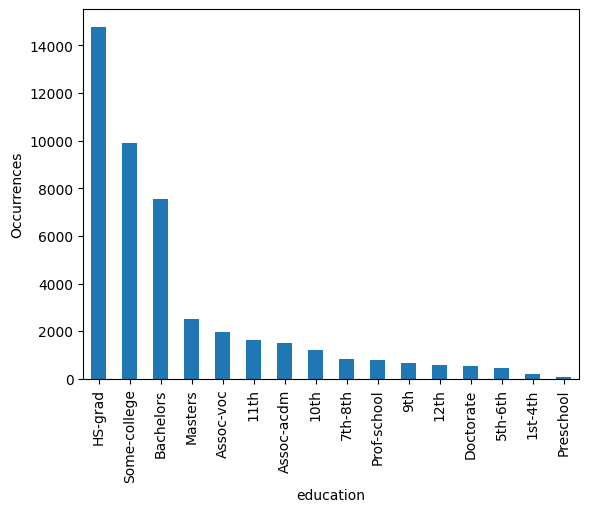

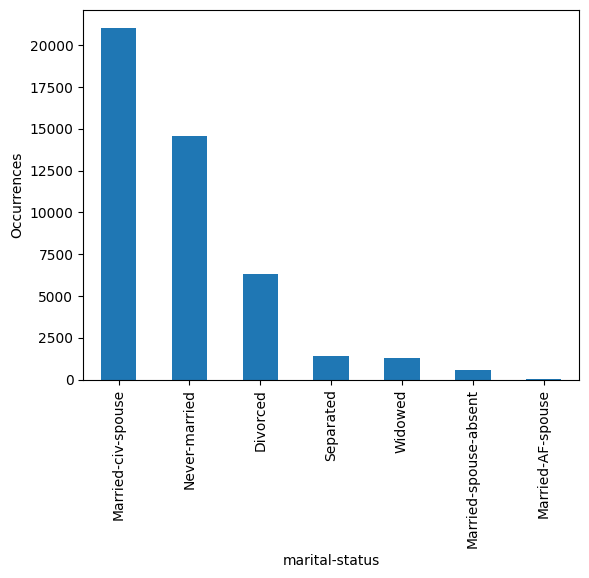

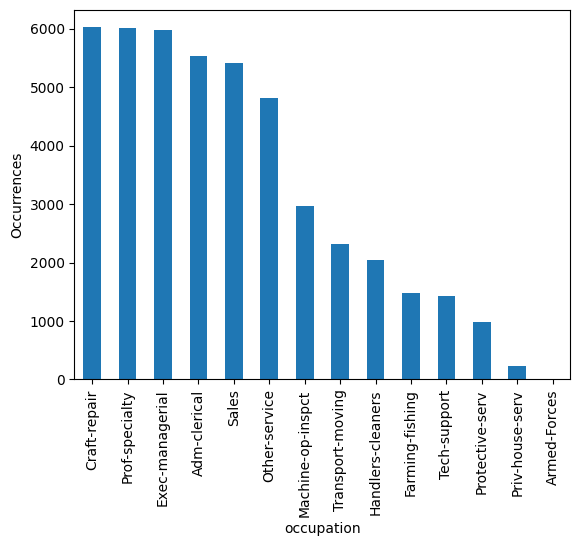

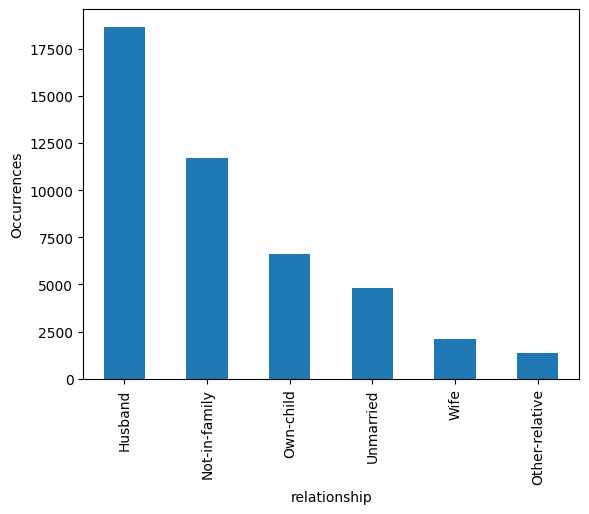

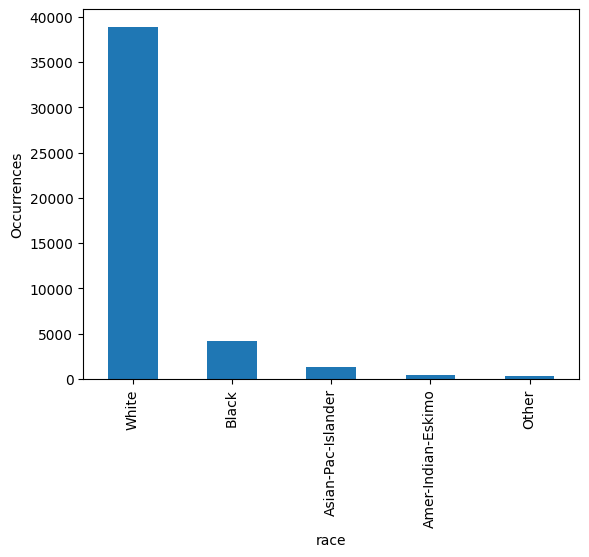

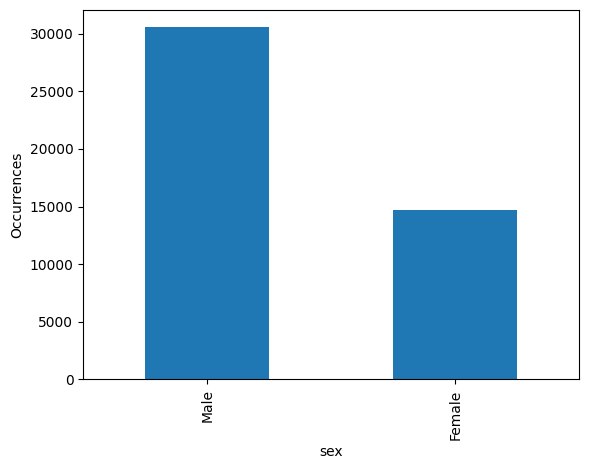

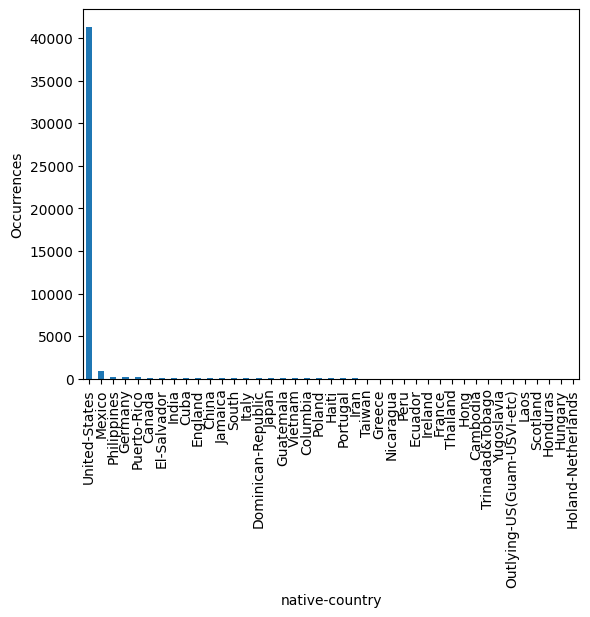

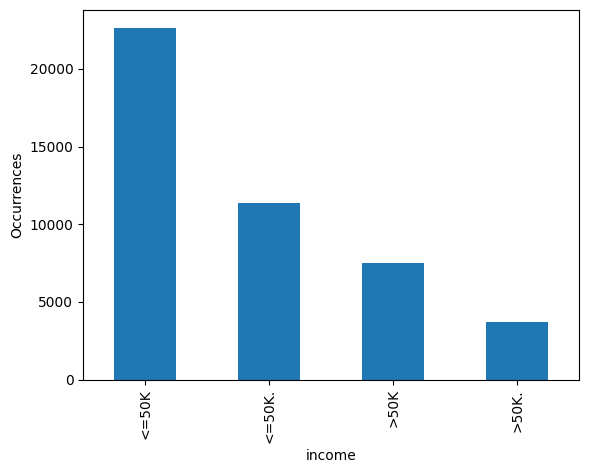

In [75]:
for cat_feature in df.select_dtypes(include='object').columns:
  df[cat_feature].value_counts().plot(kind='bar')
  plt.ylabel('Occurrences')
  plt.xlabel(cat_feature)
  plt.show()

#### Remove useless features and split into X and y

In [76]:
X = deepcopy(df.drop(['education-num', 'capital-gain', 'capital-loss', 'income'], axis=1))
y = deepcopy(df['income'])

y[(y == '<=50K.') | (y == '<=50K')] = 0
y[(y == '>50K.') | (y == '>50K')] = 1
y = y.values.astype(float)

cat_features = X.select_dtypes(include='object').columns
data_encoded = pd.get_dummies(X, columns=cat_features)
data_encoded

,age,fnlwgt,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,40,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,40,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,40,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,40,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,245211,40,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48837,39,215419,36,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48839,38,374983,50,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
48840,44,83891,40,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Standarize and split data

In [77]:
#for each feature variance = 1 and mean = 0
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data_encoded)
X_scaled.shape

(45222, 101)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

## Define models

### Train Function

In [79]:
def train_model(X_train, y_train, model, criterion, optimizer, num_epochs=10, batch_size=64):
    train_dataset = TensorDataset(X_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
      model.train()
      for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()
      print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


### Test Function

In [80]:
def evaluate_model(X_test, y_test, model):
  model.eval()
  with torch.no_grad():
    y_pred = model(X_test)
    y_pred_binary = (y_pred >= 0.5).float()
    acc = accuracy_score(y_test, y_pred_binary.numpy())
    return acc

### Logistic Regression

In [81]:
class LogisticRegression(nn.Module):
  def __init__(self, input_size):
    super(LogisticRegression, self).__init__()
    self.linear = nn.Linear(input_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.linear(x)
    x = self.sigmoid(x)
    return x

### Linear Regression

In [82]:
class LinearRegression(nn.Module):
  def __init__(self, input_size):
    super(LinearRegression, self).__init__()
    self.linear = nn.Linear(input_size, 1)

  def forward(self, x):
    x = self.linear(x)
    return x

### Black-Box: Multi-Layer Perceptron
- ReLu - activation function
- SGD Adam - optimizer (lr. η = 0.001)
- binary cross-entropy - loss function
- early stopping criterion (ToDo)

In [83]:
class MLP_Clasification(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(MLP_Clasification, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.sigmoid(x)
    return x


### Explainability Metrics: Fidelity

In [84]:
class Fidelity(nn.Module):
  def __init__(self):
    super(Fidelity, self).__init__()

  def forward(self, predictions, targets):
    loss = torch.mean((predictions - targets) ** 2)
    return loss

## Train and evaluate independently Neural Network and Linear Model

### Train MLP Model

In [85]:
#parameters
input_size = X_train_tensor.shape[1]
hidden_size = 2 * input_size + 1
epoch_num = 10
batch_size = 64

#model
mlp_base = MLP_Clasification(input_size, hidden_size)

#optimizer and criterion
optimizer_adam = torch.optim.Adam(mlp_base.parameters(), lr=0.001)
criterion_bce = nn.BCELoss()

train_model(X_train_tensor, y_train_tensor, mlp_base, criterion_bce, optimizer_adam, epoch_num, batch_size)

Epoch 1/10, Loss: 0.3773825764656067
Epoch 2/10, Loss: 0.4247126579284668
Epoch 3/10, Loss: 0.3994983434677124
Epoch 4/10, Loss: 0.3145962059497833
Epoch 5/10, Loss: 0.3751688599586487
Epoch 6/10, Loss: 0.2417520135641098
Epoch 7/10, Loss: 0.3883642554283142
Epoch 8/10, Loss: 0.26354309916496277
Epoch 9/10, Loss: 0.38771623373031616
Epoch 10/10, Loss: 0.32236242294311523


In [86]:
mlp_acc = evaluate_model(X_test_tensor, y_test_tensor, mlp_base)
mlp_acc

0.8350433398195648

### Train Linear Model

In [87]:
#model
linear_base = LogisticRegression(input_size)

#optimizer and criterion
optimizer_adam = torch.optim.Adam(linear_base.parameters(), lr=0.001)
criterion_bce = nn.BCELoss()

train_model(X_train_tensor, y_train_tensor, linear_base, criterion_bce, optimizer_adam, epoch_num, batch_size)

Epoch 1/10, Loss: 0.42140036821365356
Epoch 2/10, Loss: 0.48664286732673645
Epoch 3/10, Loss: 0.42549973726272583
Epoch 4/10, Loss: 0.4178383946418762
Epoch 5/10, Loss: 0.3825995624065399
Epoch 6/10, Loss: 0.3829526901245117
Epoch 7/10, Loss: 0.40840277075767517
Epoch 8/10, Loss: 0.331708163022995
Epoch 9/10, Loss: 0.41819727420806885
Epoch 10/10, Loss: 0.2669309675693512


In [88]:
linear_acc = evaluate_model(X_test_tensor, y_test_tensor, linear_base)
linear_acc

0.829205731470016

## Train and evaluate Single Task Learning (STL) approach

#### STL with LogisticRegression Model

In [89]:
with torch.no_grad():
  y_predicted_train = (mlp_base(X_train_tensor) >= 0.5).float()
  y_predicted_test = (mlp_base(X_test_tensor) >= 0.5).float()

#parameters
input_size = X_train_tensor.shape[1]
epoch_num = 10
batch_size = 64
lr = 0.001

#model
stl_logistic = LogisticRegression(input_size)

#criterion and optimizer
criterion_bce = nn.BCELoss()
optimizer_adam = torch.optim.Adam(stl_logistic.parameters(), lr=lr)

train_model(X_train_tensor, y_predicted_train, stl_logistic, criterion_bce, optimizer_adam, epoch_num, batch_size)

Epoch 1/10, Loss: 0.32718899846076965
Epoch 2/10, Loss: 0.2578205168247223
Epoch 3/10, Loss: 0.1989990770816803
Epoch 4/10, Loss: 0.17131982743740082
Epoch 5/10, Loss: 0.1410626322031021
Epoch 6/10, Loss: 0.21631011366844177
Epoch 7/10, Loss: 0.2294185757637024
Epoch 8/10, Loss: 0.16434675455093384
Epoch 9/10, Loss: 0.12138152122497559
Epoch 10/10, Loss: 0.15129454433918


In [90]:
with torch.no_grad():
  stl_logistic.eval()
  stl_y_predicted = stl_logistic(X_test_tensor)

fidelity_criterion = Fidelity()
stl_loss = fidelity_criterion(stl_y_predicted, y_predicted_test)
stl_loss

tensor(0.0443)

## Train and evaluate Multi Task Learing approach
- soft parameter sharing
- MLP and LogisticRegression
- with Fidelity metric
- α - parameter

### Define Model

In [91]:
class MTL_mlp_linear(nn.Module):
  def __init__(self, mlp_model, logistic_model):
    super(MTL_mlp_linear, self).__init__()
    self.mlp = mlp_model
    self.logistic = logistic_model

  def forward(self, x):
    mlp_output = self.mlp(x)
    logistic_output = self.logistic(x)
    return mlp_output, logistic_output

### Define training and evaluation methods

In [92]:
def train_mtl_model(X_train, y_train, model, criterion_mlp, criterion_log, optimizer, alpha=0.5, epoch_num=10, batch_size=64):
  train_dataset = TensorDataset(X_train, y_train)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

  for epoch in range(epoch_num):
    model.train()
    for inputs, labels in train_loader:
      optimizer.zero_grad()

      mlp_output, logistic_output = model(inputs)

      loss_mlp = criterion_mlp(mlp_output, labels.view(-1, 1))
      loss_log = criterion_log(logistic_output, mlp_output)
      total_loss = alpha * loss_mlp + (1-alpha) * loss_log
      total_loss.backward()
      optimizer.step()
    print(f'Epoch {epoch + 1}/{epoch_num}, Loss MLP: {loss_mlp.item()}, Loss Logistic: {loss_log.item()}')

In [93]:
# calculate Fidelity for rounded output (0 or 1)
def eval_mtl_model(X_test, y_test, model):
  model.eval()
  with torch.no_grad():
    y_pred_mlp, y_pred_log = model(X_test)
    y_pred_mlp_bin = (y_pred_mlp >= 0.5).float()
    y_pred_log_bin = (y_pred_log >= 0.5).float()

    accuracy = accuracy_score(y_test, y_pred_mlp_bin.numpy())
    fidelity = Fidelity()
    fidelity_score = fidelity(y_pred_log_bin, y_pred_mlp_bin)
    return accuracy, fidelity_score

In [94]:
# calculate Fitedility without rounding
def eval_mtl_model_raw(X_test, y_test, model):
  model.eval()
  with torch.no_grad():
    y_pred_mlp, y_pred_log = model(X_test)
    y_pred_mlp_bin = (y_pred_mlp >= 0.5).float()
    accuracy = accuracy_score(y_test, y_pred_mlp_bin.numpy())
    fidelity = Fidelity()
    fidelity_score = fidelity(y_pred_log, y_pred_mlp)
    return accuracy, fidelity_score

In [95]:
def train_and_eval_with_different_alphas(alphas_list, folder_path, name, X_train, y_train, X_test, y_test, raw=False):
  input_size = X_train.shape[1]
  hidden_size = input_size * 2 + 1
  lr = 0.001
  accuracy_lst = []
  fidelity_lst = []
  for alpha in alphas_list:
    print(f'Model for alpha={alpha}')
    mlp = MLP_Clasification(input_size, hidden_size)
    log = LogisticRegression(input_size)
    model = MTL_mlp_linear(mlp, log)
    path = folder_path + '/' + name + f'_alpha_{alpha}' + '.pt'

    try:
      model.load_state_dict(torch.load(path))
      print(f'Model {path} loaded successfully')
    except:
      criterion_mlp = nn.BCELoss()
      criterion_log = Fidelity()
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)
      train_mtl_model(X_train, y_train, model, criterion_mlp, criterion_log, optimizer, alpha)
      torch.save(model.state_dict(), path)
      print(f'Model {path} trained successfully')
    if raw:
      acc, fid = eval_mtl_model_raw(X_test, y_test, model)
    else:
      acc, fid = eval_mtl_model(X_test, y_test, model)
    print(f'Model {path}: Accuracy: {acc.item()}, Fidelity: {fid.item()}')
    accuracy_lst.append(round(acc.item(), 5))
    fidelity_lst.append(round(fid.item(), 5))
  return accuracy_lst, fidelity_lst

### Training and evaluation of models (MLP + LogReg) with different values of the alpha parameter (from 0 to 1 with 0.1 step). Fidelity on rounded outputs.

In [96]:
path = f"drive/My Drive/Models/round_log"
name = 'mtl_model_mlp_log'
alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
acc_lst, fid_lst = train_and_eval_with_different_alphas(alphas, path, name, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)


Model for alpha=0
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.pt loaded successfully
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.pt: Accuracy: 0.532549088979303, Fidelity: 0.02892269566655159
Model for alpha=0.1
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.1.pt loaded successfully
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.1.pt: Accuracy: 0.8371661064921281, Fidelity: 0.019370246678590775
Model for alpha=0.2
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.2.pt loaded successfully
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.2.pt: Accuracy: 0.8393773217760481, Fidelity: 0.025915443897247314
Model for alpha=0.3
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.3.pt loaded successfully
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.3.pt: Accuracy: 0.8422076773394658, Fidelity: 0.038475144654512405
Model for alpha=0.4
Model drive/My Drive/Models/

### Plots for models (MLP + LogReg) trained with different alpha values in range 0 to 1 with step 0.1 compared with STL approach (Fidelity calculated on rounded outputs)

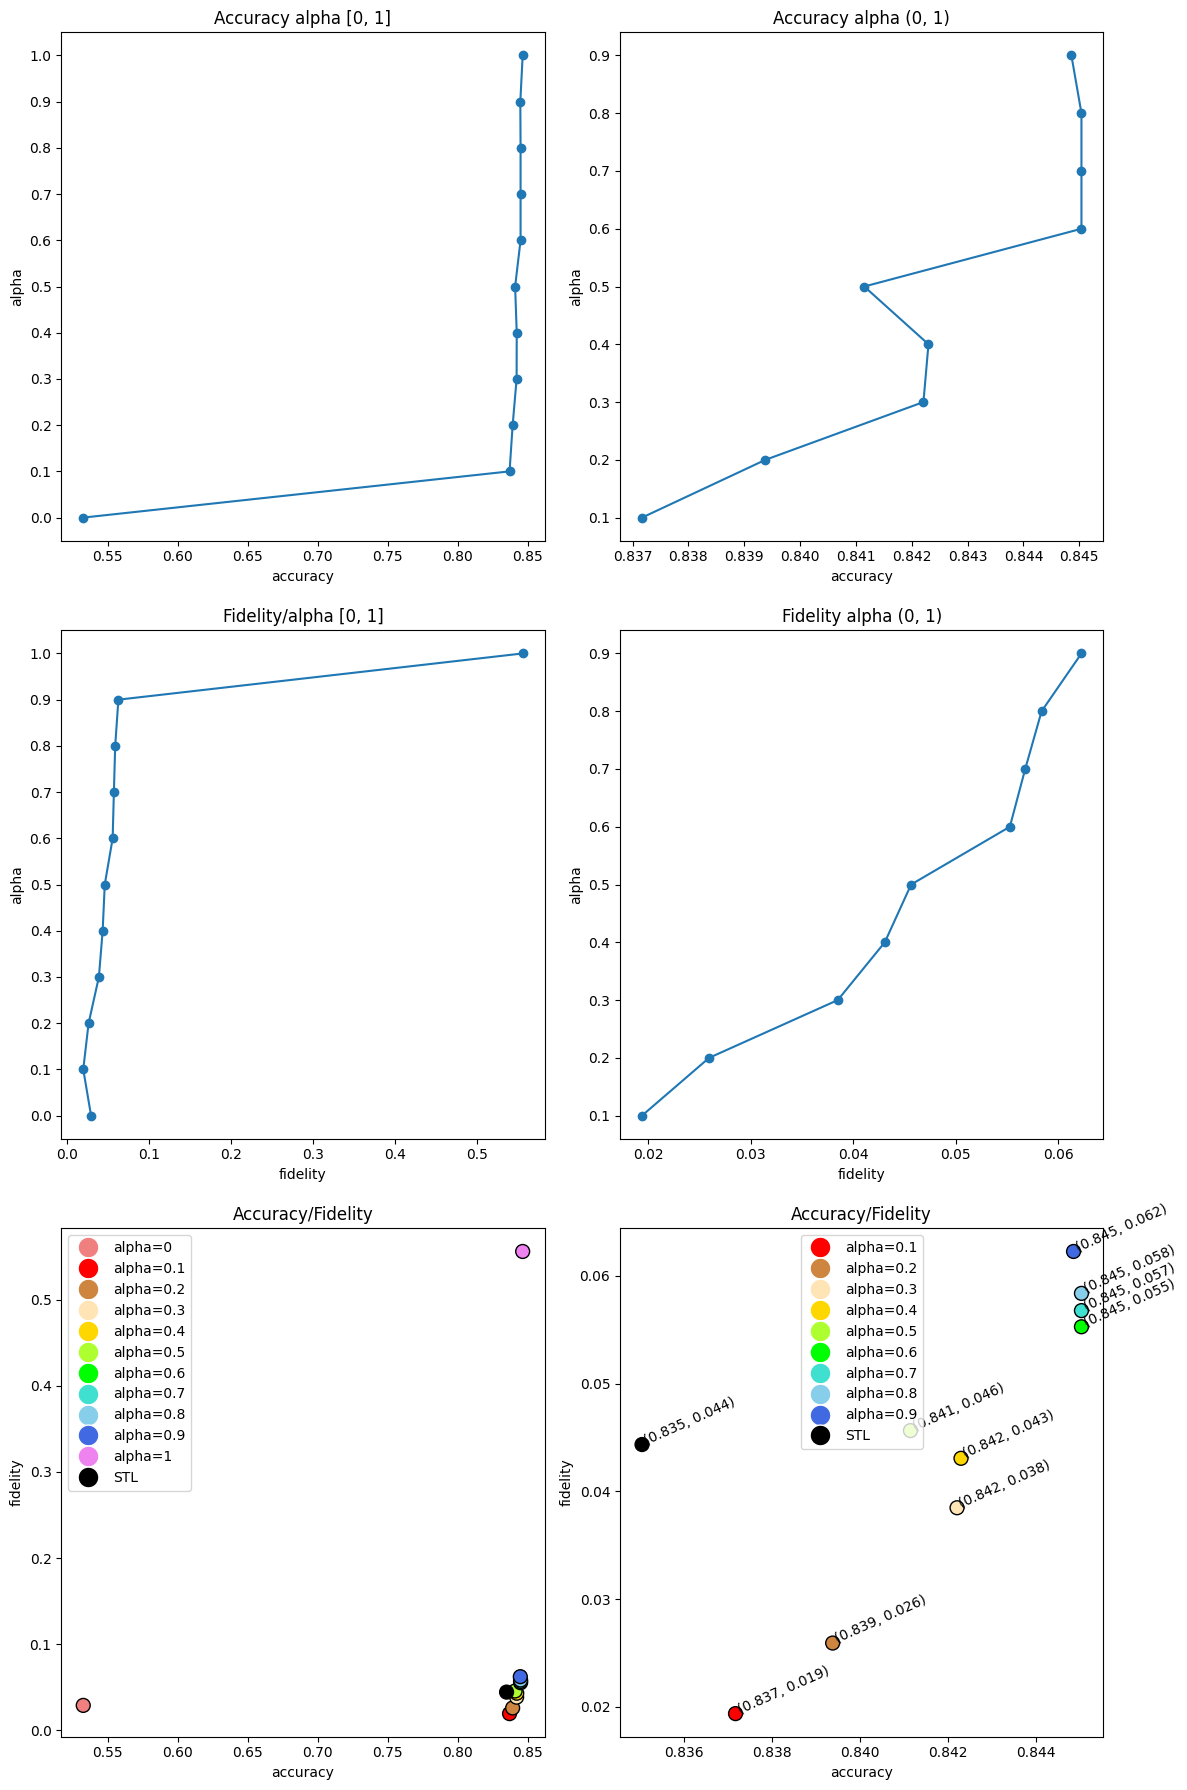

In [97]:
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# alpha/accuracy
axs[0,0].plot(acc_lst, alphas, marker='o')
axs[0,0].set_ylabel('alpha')
axs[0,0].set_yticks(ticks=alphas)
axs[0,0].set_xlabel('accuracy')
axs[0,0].set_title(label='Accuracy alpha [0, 1]')

axs[0,1].plot(acc_lst[1:-1], alphas[1:-1], marker='o')
axs[0,1].set_ylabel('alpha')
axs[0,1].set_yticks(ticks=alphas[1:-1])
axs[0,1].set_xlabel('accuracy')
axs[0,1].set_title(label='Accuracy alpha (0, 1)')

# alpha/fidelity
axs[1,0].plot(fid_lst, alphas, marker='o')
axs[1,0].set_ylabel('alpha')
axs[1,0].set_yticks(ticks=alphas)
axs[1,0].set_xlabel('fidelity')
axs[1,0].set_title(label='Fidelity/alpha [0, 1]')

axs[1,1].plot(fid_lst[1:-1], alphas[1:-1], marker='o')
axs[1,1].set_ylabel('alpha')
axs[1,1].set_yticks(ticks=alphas[1:-1])
axs[1,1].set_xlabel('fidelity')
axs[1,1].set_title(label='Fidelity alpha (0, 1)')

# Accuracy/Fidelity
acc_lst_ex = acc_lst + [mlp_acc]
fid_lst_ex = fid_lst + [stl_loss]
colors = ['lightcoral', 'red', 'peru', 'moccasin', 'gold', 'greenyellow', 'lime', 'turquoise', 'skyblue', 'royalblue', 'violet', 'black']
alpha_legend = [f'alpha={i}' for i in alphas]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15) for color in colors]

axs[2,0].scatter(acc_lst_ex, fid_lst_ex, label='Accuracy/Fidelity', marker='o', s=100, edgecolors='black', c=colors)
axs[2,0].set_title('Accuracy/Fidelity')
axs[2,0].legend(legend_handles, alpha_legend + ['STL'])
axs[2,0].set_ylabel('fidelity')
axs[2,0].set_xlabel('accuracy')

acc_lst_ex = acc_lst[1:-1] + [mlp_acc]
fid_lst_ex = fid_lst[1:-1] + [stl_loss]
colors = ['red', 'peru', 'moccasin', 'gold', 'greenyellow', 'lime', 'turquoise', 'skyblue', 'royalblue', 'black']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15) for color in colors]

axs[2,1].scatter(acc_lst_ex, fid_lst_ex, label='Accuracy/Fidelity', marker='o', s=100, edgecolors='black', c=colors)
axs[2,1].set_title('Accuracy/Fidelity')
axs[2,1].legend(legend_handles, alpha_legend[1:-1] + ['STL'], loc='upper center')
axs[2,1].set_ylabel('fidelity')
axs[2,1].set_xlabel('accuracy')
for x, y in zip(acc_lst_ex, fid_lst_ex):
  axs[2,1].annotate(f'({round(float(x), 3)}, {round(float(y), 3)})', (x, y), rotation=24)

plt.tight_layout()
plt.show()

### Training and evaluation of models (MLP + LogReg) with different values of the alpha parameter (from 0 to 1 with 0.1 step). Fidelity calculated on raw outputs.

In [98]:
path = f"drive/My Drive/Models/round_log"
name = 'mtl_model_mlp_log'
alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
acc_lst, fid_lst = train_and_eval_with_different_alphas(alphas, path, name, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, raw=True)


Model for alpha=0
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.pt loaded successfully
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.pt: Accuracy: 0.532549088979303, Fidelity: 3.3552882086951286e-05
Model for alpha=0.1
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.1.pt loaded successfully
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.1.pt: Accuracy: 0.8371661064921281, Fidelity: 0.0008744981605559587
Model for alpha=0.2
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.2.pt loaded successfully
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.2.pt: Accuracy: 0.8393773217760481, Fidelity: 0.0021874045487493277
Model for alpha=0.3
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.3.pt loaded successfully
Model drive/My Drive/Models/round_log/mtl_model_mlp_log_alpha_0.3.pt: Accuracy: 0.8422076773394658, Fidelity: 0.004068129230290651
Model for alpha=0.4
Model drive/My Drive/Mo

### Plots for models (MLP + LogReg) trained with different alpha values in range 0 to 1 with step 0.1. (Fidelity calculated on raw outputs)

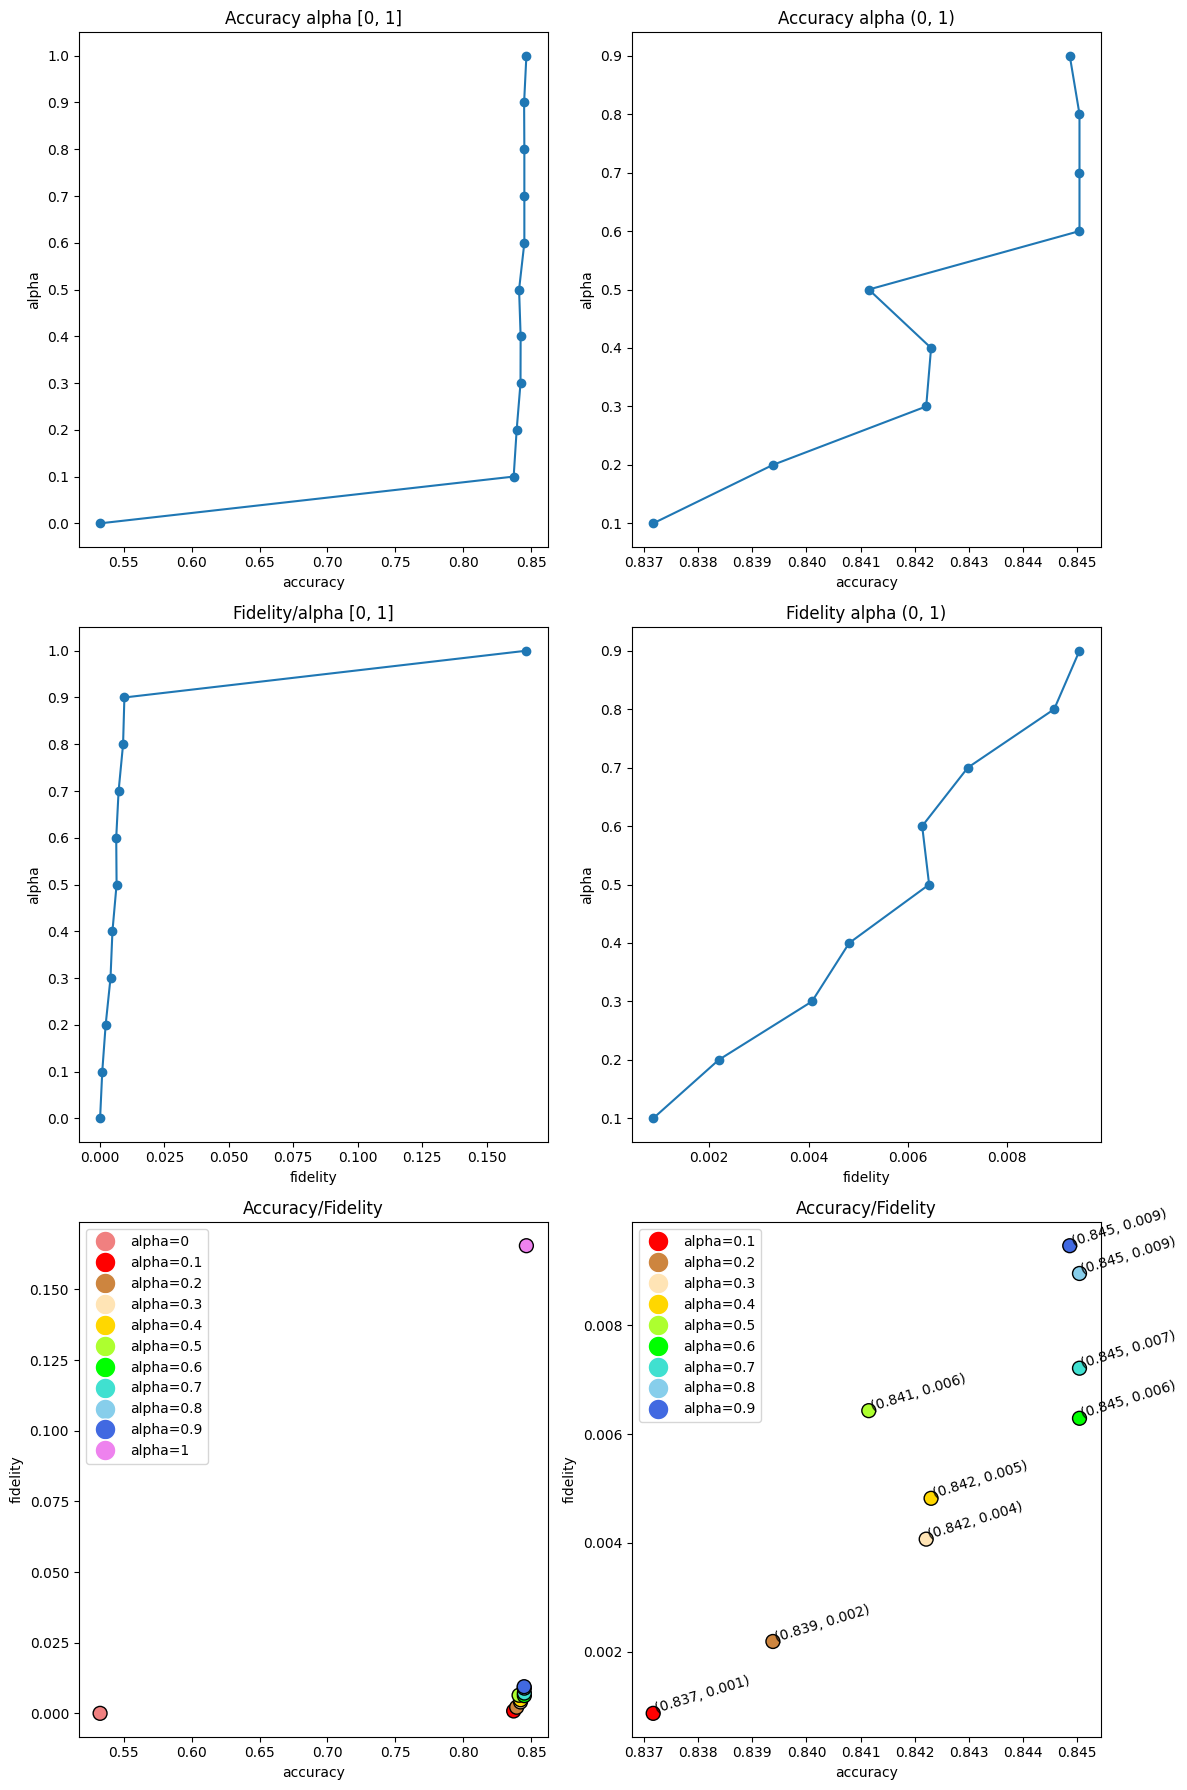

In [99]:
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# alpha/accuracy
axs[0,0].plot(acc_lst, alphas, marker='o')
axs[0,0].set_ylabel('alpha')
axs[0,0].set_yticks(ticks=alphas)
axs[0,0].set_xlabel('accuracy')
axs[0,0].set_title(label='Accuracy alpha [0, 1]')

axs[0,1].plot(acc_lst[1:-1], alphas[1:-1], marker='o')
axs[0,1].set_ylabel('alpha')
axs[0,1].set_yticks(ticks=alphas[1:-1])
axs[0,1].set_xlabel('accuracy')
axs[0,1].set_title(label='Accuracy alpha (0, 1)')

# alpha/fidelity
axs[1,0].plot(fid_lst, alphas, marker='o')
axs[1,0].set_ylabel('alpha')
axs[1,0].set_yticks(ticks=alphas)
axs[1,0].set_xlabel('fidelity')
axs[1,0].set_title(label='Fidelity/alpha [0, 1]')

axs[1,1].plot(fid_lst[1:-1], alphas[1:-1], marker='o')
axs[1,1].set_ylabel('alpha')
axs[1,1].set_yticks(ticks=alphas[1:-1])
axs[1,1].set_xlabel('fidelity')
axs[1,1].set_title(label='Fidelity alpha (0, 1)')

colors = ['turquoise' for _ in range(11)]
colors = ['lightcoral', 'red', 'peru', 'moccasin', 'gold', 'greenyellow', 'lime', 'turquoise', 'skyblue', 'royalblue', 'violet']
alpha_legend = [f'alpha={i}' for i in alphas]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15) for color in colors]

axs[2,0].scatter(acc_lst, fid_lst, label='Accuracy/Fidelity', marker='o', s=100, edgecolors='black', c=colors)
axs[2,0].set_title('Accuracy/Fidelity')
axs[2,0].legend(legend_handles, alpha_legend)
axs[2,0].set_ylabel('fidelity')
axs[2,0].set_xlabel('accuracy')

colors = ['red', 'peru', 'moccasin', 'gold', 'greenyellow', 'lime', 'turquoise', 'skyblue', 'royalblue']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15) for color in colors]

axs[2,1].scatter(acc_lst[1:-1], fid_lst[1:-1], label='Accuracy/Fidelity', marker='o', s=100, edgecolors='black', c=colors)
axs[2,1].set_title('Accuracy/Fidelity')
axs[2,1].legend(legend_handles, alpha_legend[1:-1])
axs[2,1].set_ylabel('fidelity')
axs[2,1].set_xlabel('accuracy')
for x, y in zip(acc_lst[1:-1], fid_lst[1:-1]):
  axs[2,1].annotate(f'({round(x, 3)}, {round(y, 3)})', (x, y), rotation=17)

plt.tight_layout()
plt.show()

### Training and evaluation of models (MLP + LinearReg) with different values of the alpha parameter (from 0 to 1 with 0.1 step). Fidelity on rounded outputs.

In [100]:
path = f"drive/MyDrive/Models/reg"
name = 'mtl_model_mlp_log'
alphas = alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
acc_lst, fid_lst = train_and_eval_with_different_alphas(alphas, path, name, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, raw=False)

Model for alpha=0
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.pt loaded successfully
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.pt: Accuracy: 0.6135680169821334, Fidelity: 0.012205908074975014
Model for alpha=0.1
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.1.pt loaded successfully
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.1.pt: Accuracy: 0.8373430037148417, Fidelity: 0.01857420802116394
Model for alpha=0.2
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.2.pt loaded successfully
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.2.pt: Accuracy: 0.8382274898284097, Fidelity: 0.026888377964496613
Model for alpha=0.3
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.3.pt loaded successfully
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.3.pt: Accuracy: 0.8407924995577569, Fidelity: 0.03980187326669693
Model for alpha=0.4
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.4.pt loaded successfully
Mo

### Plots for models (MLP + LinearReg) trained with different alpha values in range 0 to 1 with step 0.1 compared with STL approach (Fidelity calculated on rounded outputs)

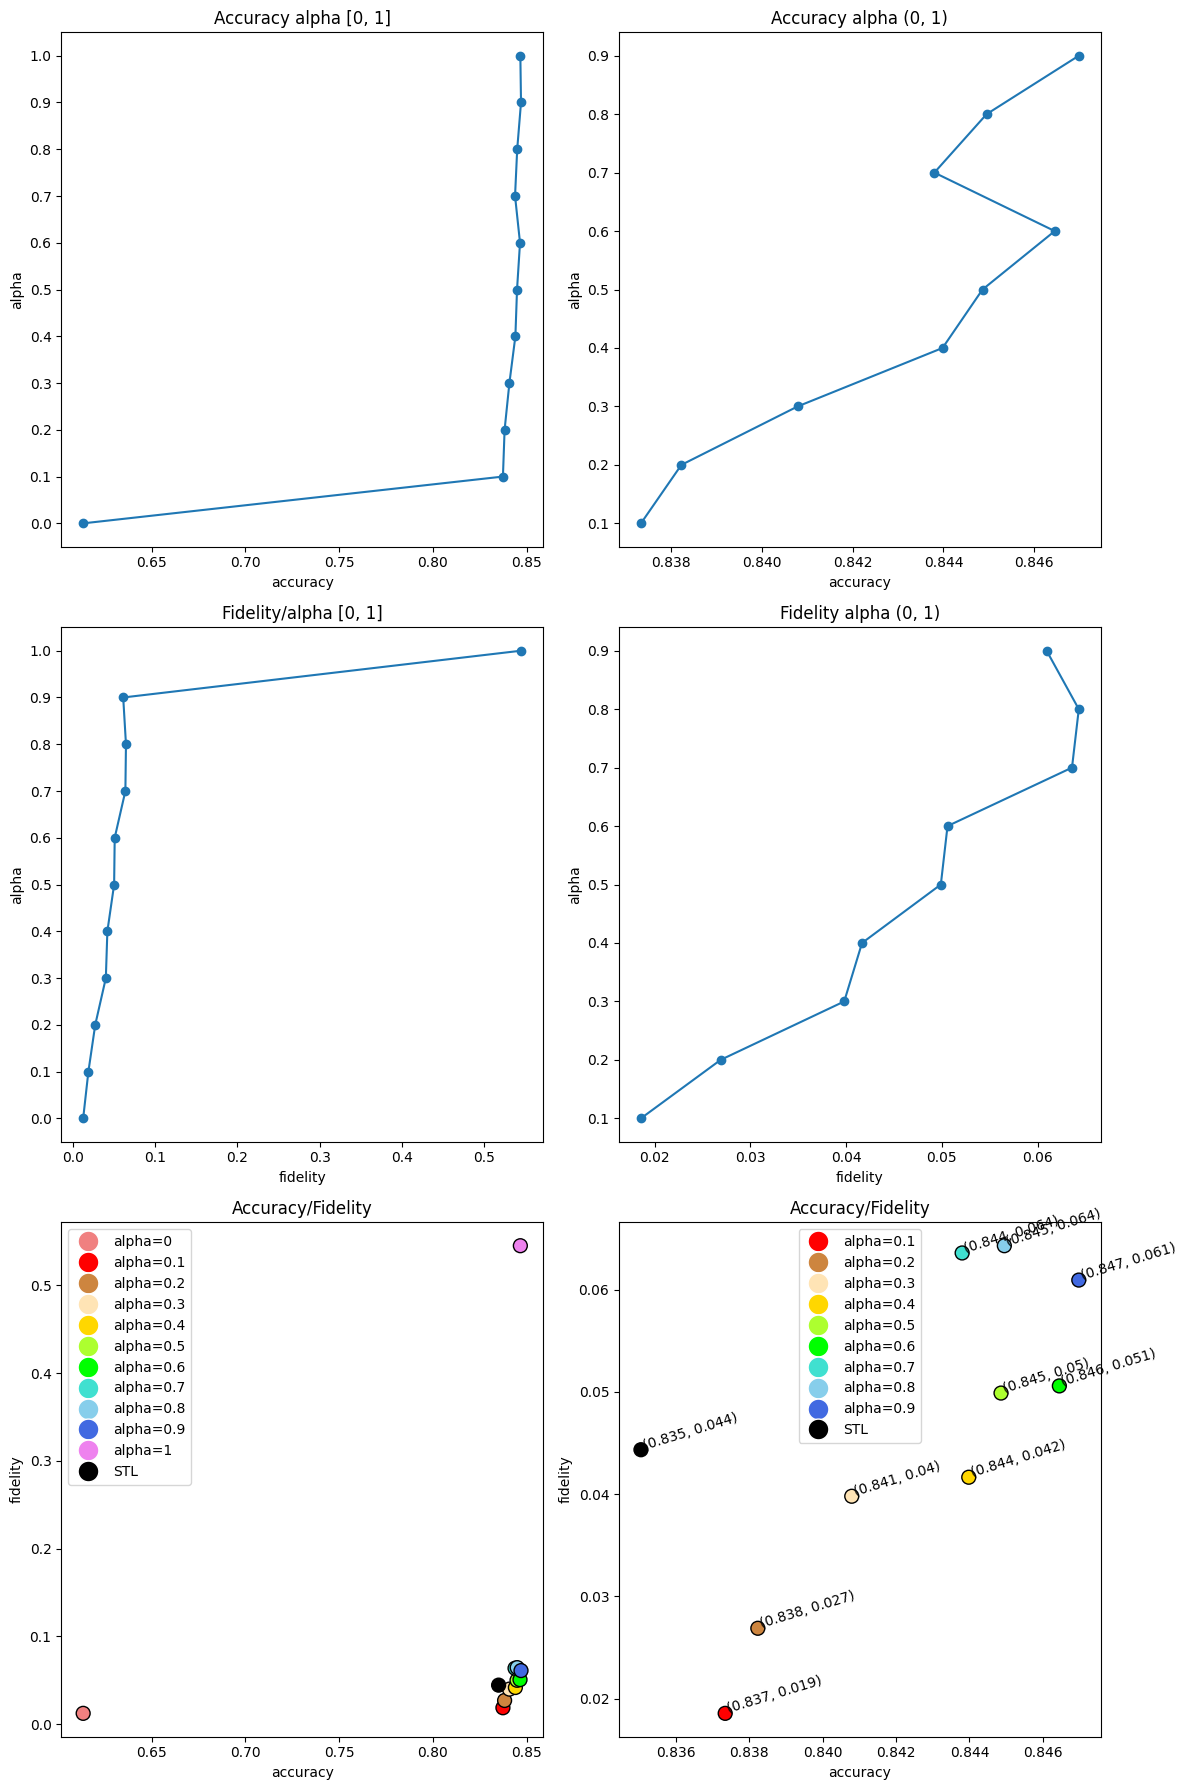

In [101]:
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# alpha/accuracy
axs[0,0].plot(acc_lst, alphas, marker='o')
axs[0,0].set_ylabel('alpha')
axs[0,0].set_yticks(ticks=alphas)
axs[0,0].set_xlabel('accuracy')
axs[0,0].set_title(label='Accuracy alpha [0, 1]')

axs[0,1].plot(acc_lst[1:-1], alphas[1:-1], marker='o')
axs[0,1].set_ylabel('alpha')
axs[0,1].set_yticks(ticks=alphas[1:-1])
axs[0,1].set_xlabel('accuracy')
axs[0,1].set_title(label='Accuracy alpha (0, 1)')

# alpha/fidelity
axs[1,0].plot(fid_lst, alphas, marker='o')
axs[1,0].set_ylabel('alpha')
axs[1,0].set_yticks(ticks=alphas)
axs[1,0].set_xlabel('fidelity')
axs[1,0].set_title(label='Fidelity/alpha [0, 1]')

axs[1,1].plot(fid_lst[1:-1], alphas[1:-1], marker='o')
axs[1,1].set_ylabel('alpha')
axs[1,1].set_yticks(ticks=alphas[1:-1])
axs[1,1].set_xlabel('fidelity')
axs[1,1].set_title(label='Fidelity alpha (0, 1)')

# Accuracy/Fidelity
acc_lst_ex = acc_lst + [mlp_acc]
fid_lst_ex = fid_lst + [stl_loss]
colors = ['lightcoral', 'red', 'peru', 'moccasin', 'gold', 'greenyellow', 'lime', 'turquoise', 'skyblue', 'royalblue', 'violet', 'black']
alpha_legend = [f'alpha={i}' for i in alphas]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15) for color in colors]

axs[2,0].scatter(acc_lst_ex, fid_lst_ex, label='Accuracy/Fidelity', marker='o', s=100, edgecolors='black', c=colors)
axs[2,0].set_title('Accuracy/Fidelity')
axs[2,0].legend(legend_handles, alpha_legend + ['STL'])
axs[2,0].set_ylabel('fidelity')
axs[2,0].set_xlabel('accuracy')

acc_lst_ex = acc_lst[1:-1] + [mlp_acc]
fid_lst_ex = fid_lst[1:-1] + [stl_loss]
colors = ['red', 'peru', 'moccasin', 'gold', 'greenyellow', 'lime', 'turquoise', 'skyblue', 'royalblue', 'black']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15) for color in colors]

axs[2,1].scatter(acc_lst_ex, fid_lst_ex, label='Accuracy/Fidelity', marker='o', s=100, edgecolors='black', c=colors)
axs[2,1].set_title('Accuracy/Fidelity')
axs[2,1].legend(legend_handles, alpha_legend[1:-1] + ['STL'], loc='upper center')
axs[2,1].set_ylabel('fidelity')
axs[2,1].set_xlabel('accuracy')
for x, y in zip(acc_lst_ex, fid_lst_ex):
  axs[2,1].annotate(f'({round(float(x), 3)}, {round(float(y), 3)})', (x, y), rotation=17)

plt.tight_layout()
plt.show()

### Training and evaluation of models (MLP + LinearReg) with different values of the alpha parameter (from 0 to 1 with 0.1 step). Fidelity on raw outputs.

In [102]:
def train_and_eval_with_different_alphas_reg(alphas_list, folder_path, name, X_train, y_train, X_test, y_test, raw=False):
  input_size = X_train.shape[1]
  hidden_size = input_size * 2 + 1
  lr = 0.001
  accuracy_lst = []
  fidelity_lst = []
  for alpha in alphas_list:
    print(f'Model for alpha={alpha}')
    mlp = MLP_Clasification(input_size, hidden_size)
    reg = LinearRegression(input_size)
    model = MTL_mlp_linear(mlp, reg)
    path = folder_path + '/' + name + f'_alpha_{alpha}' + '.pt'

    # print('TRY')
    try:
      model.load_state_dict(torch.load(path))
      print(f'Model {path} loaded successfully')
    except:
      criterion_mlp = nn.BCELoss()
      criterion_log = Fidelity()
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)
      train_mtl_model(X_train, y_train, model, criterion_mlp, criterion_log, optimizer, alpha)
      torch.save(model.state_dict(), path)
      print(f'Model {path} trained successfully')
    if raw:
      acc, fid = eval_mtl_model_raw(X_test, y_test, model)
    else:
      acc, fid = eval_mtl_model(X_test, y_test, model)
    print(f'Model {path}: Accuracy: {acc.item()}, Fidelity: {fid.item()}')
    accuracy_lst.append(round(acc.item(), 5))
    fidelity_lst.append(round(fid.item(), 5))
  return accuracy_lst, fidelity_lst

In [103]:
path = f"drive/MyDrive/Models/reg"
name = 'mtl_model_mlp_log'
alphas = alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
acc_lst, fid_lst = train_and_eval_with_different_alphas(alphas, path, name, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, raw=True)

Model for alpha=0
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.pt loaded successfully
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.pt: Accuracy: 0.6135680169821334, Fidelity: 3.989892138633877e-05
Model for alpha=0.1
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.1.pt loaded successfully
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.1.pt: Accuracy: 0.8373430037148417, Fidelity: 0.0008281795307993889
Model for alpha=0.2
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.2.pt loaded successfully
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.2.pt: Accuracy: 0.8382274898284097, Fidelity: 0.0019407751969993114
Model for alpha=0.3
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.3.pt loaded successfully
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.3.pt: Accuracy: 0.8407924995577569, Fidelity: 0.0037576924078166485
Model for alpha=0.4
Model drive/MyDrive/Models/reg/mtl_model_mlp_log_alpha_0.4.pt loaded successfu

### Plots for models (MLP + LinearReg) trained with different alpha values in range 0 to 1 with step 0.1. (Fidelity calculated on raw outputs)

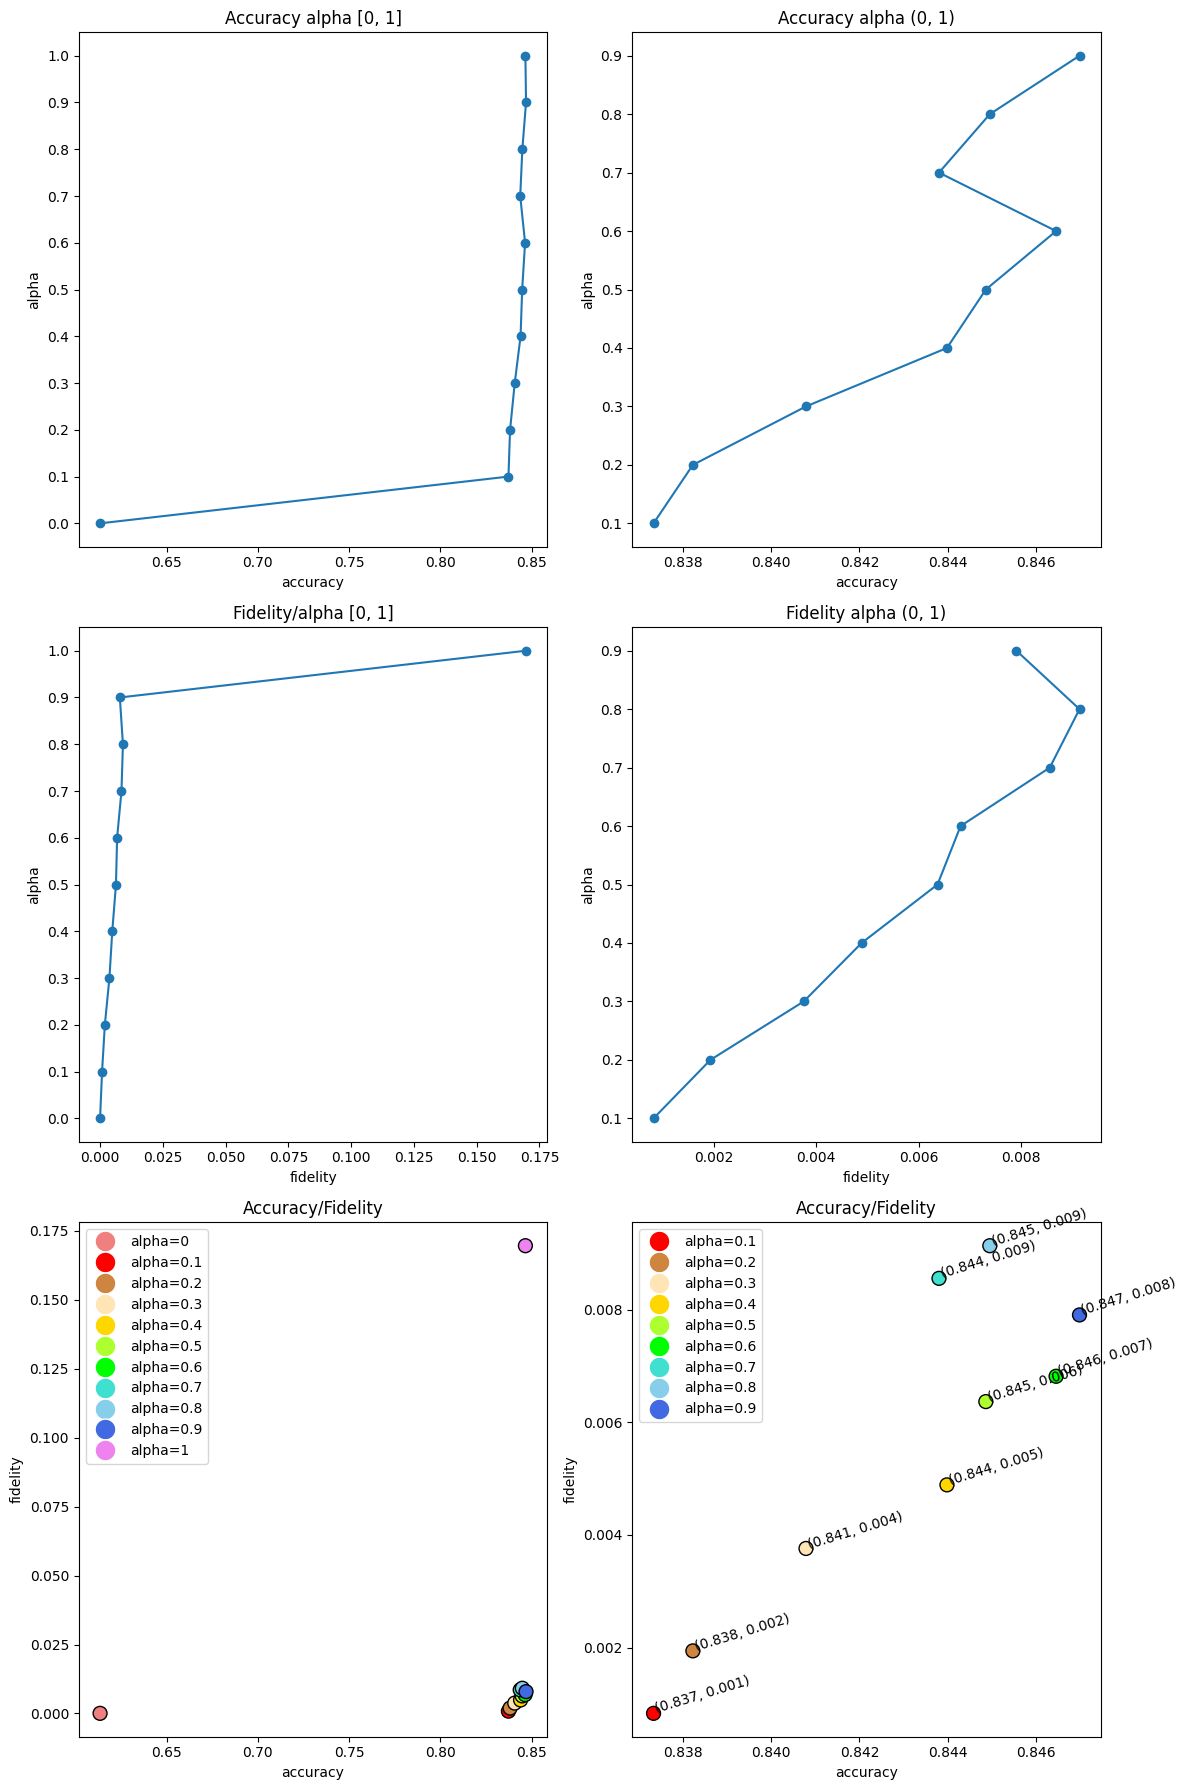

In [104]:
fig, axs = plt.subplots(3, 2, figsize=(12, 18))

# alpha/accuracy
axs[0,0].plot(acc_lst, alphas, marker='o')
axs[0,0].set_ylabel('alpha')
axs[0,0].set_yticks(ticks=alphas)
axs[0,0].set_xlabel('accuracy')
axs[0,0].set_title(label='Accuracy alpha [0, 1]')

axs[0,1].plot(acc_lst[1:-1], alphas[1:-1], marker='o')
axs[0,1].set_ylabel('alpha')
axs[0,1].set_yticks(ticks=alphas[1:-1])
axs[0,1].set_xlabel('accuracy')
axs[0,1].set_title(label='Accuracy alpha (0, 1)')

# alpha/fidelity
axs[1,0].plot(fid_lst, alphas, marker='o')
axs[1,0].set_ylabel('alpha')
axs[1,0].set_yticks(ticks=alphas)
axs[1,0].set_xlabel('fidelity')
axs[1,0].set_title(label='Fidelity/alpha [0, 1]')

axs[1,1].plot(fid_lst[1:-1], alphas[1:-1], marker='o')
axs[1,1].set_ylabel('alpha')
axs[1,1].set_yticks(ticks=alphas[1:-1])
axs[1,1].set_xlabel('fidelity')
axs[1,1].set_title(label='Fidelity alpha (0, 1)')

colors = ['turquoise' for _ in range(11)]
colors = ['lightcoral', 'red', 'peru', 'moccasin', 'gold', 'greenyellow', 'lime', 'turquoise', 'skyblue', 'royalblue', 'violet']
alpha_legend = [f'alpha={i}' for i in alphas]
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15) for color in colors]

axs[2,0].scatter(acc_lst, fid_lst, label='Accuracy/Fidelity', marker='o', s=100, edgecolors='black', c=colors)
axs[2,0].set_title('Accuracy/Fidelity')
axs[2,0].legend(legend_handles, alpha_legend)
axs[2,0].set_ylabel('fidelity')
axs[2,0].set_xlabel('accuracy')

colors = ['red', 'peru', 'moccasin', 'gold', 'greenyellow', 'lime', 'turquoise', 'skyblue', 'royalblue']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15) for color in colors]

axs[2,1].scatter(acc_lst[1:-1], fid_lst[1:-1], label='Accuracy/Fidelity', marker='o', s=100, edgecolors='black', c=colors)
axs[2,1].set_title('Accuracy/Fidelity')
axs[2,1].legend(legend_handles, alpha_legend[1:-1])
axs[2,1].set_ylabel('fidelity')
axs[2,1].set_xlabel('accuracy')
for x, y in zip(acc_lst[1:-1], fid_lst[1:-1]):
  axs[2,1].annotate(f'({round(x, 3)}, {round(y, 3)})', (x, y), rotation=17)

plt.tight_layout()
plt.show()